In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, date
import os
import re
import json
import math
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from functools import reduce

os.chdir('../Tools/libs/')
import text_mining_lib as tmlib
os.chdir('../vk_upload/')
import vk_api
os.chdir('../../BrandSocmediaDashboard/')

%matplotlib inline
pd.set_option('mode.chained_assignment', None)

In [2]:
brand_list = ['MMX', 'Agusha', 'Adrenaline', 'LADA', 'Retail', 'Alfabank', 'Daimler']

In [3]:
taxonomy = pd.read_csv('../DATA/Taxonomy/Custom_Taxonomy_Vk.csv', encoding='cp1251', sep=';', header=0, index_col=(0, 1))

In [ ]:
add_part = False
today = str(date.today())
chunk = 20000

for brand in ['mmx']:
    brand = brand.lower()
    filename = f'youscan_{brand}_total'
    
    #загрузка параметров    
    with open(f'modeling/{brand}_config.json', 'r') as f:
        configs = json.load(f)

    print('загрузка данных')
    files = os.listdir('../DATA/BrandSocmediaDashboard/processed/')
    #Если мы строим датасет в первый раз и хотим обработать все, что есть
    if not add_part:
        #Может, мы еще не сохраняли предобработанный датасет
        if f'{filename}-processed.csv' not in files:
            print('Запуск предобработки')
            df = pd.read_csv(f'../DATA/BrandSocmediaDashboard/{filename}.csv', sep=';')
#             df = df.sample(frac=0.05)
            df = tmlib.first_process(df)
            df = tmlib.delete_unwanted_mentions(df, configs['unwanted_mentions'])   
            df = tmlib.cross_posting_remove(df)
            df = df.applymap(tmlib.replace_semicolon)
            df.to_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-processed.csv', index=False, sep=';')
        #Если же все уже обработано, то просто загружаем
        else:
            df = pd.read_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-processed.csv', sep=';')
#             df = df.sample(min([10000, len(df)]))
#             df = df.sample(frac=0.1)
            df = tmlib.delete_unwanted_mentions(df, configs['unwanted_mentions']) 
            df = df.applymap(tmlib.replace_semicolon)
    #Но может мы хотим обработать только часть
    else:
        #Тогда загрузим необработанный полный датасет
        df = pd.read_csv(f'../DATA/BrandSocmediaDashboard/{filename}.csv')
        #поищем обработанный датасет в папке out 
        #(это значит, что у нас датасеты как минимум один раз дублируется, 
        #ну что ж, значит такая судьба, но вообще подумать)
        files_out = [f for f in os.listdir(f'DATA/') if f'dashboard-table_bsd_{brand}_youscan' in f]
        #Если такие файлы есть, то выберем последний
        if len(files_out)>0:
            old_ids = list(pd.read_csv('DATA/'+sorted(files_out)[-1])['postId'].unique())
            #И возьмем только записи, которые мы еще не обрабатывали
            df = df[~df['postId'].isin(old_ids)]
        df = tmlib.first_process(df, f'{filename}_part-{today}')
        df = tmlib.delete_unwanted_mentions(df, configs['unwanted_mentions'])   
        df = tmlib.cross_posting_remove(df)

    init_columns = df.columns   
    #создание тематик
    post_ids = {}
    print('тематики')
    for category in list(configs['brand_dict'].keys()):
        print('    ', category)
        total_df = []        
        for k in tqdm(range(math.ceil(len(df)/chunk))):
    
            cat_df_k = tmlib.build_topics(df.iloc[chunk*k:chunk*(k+1), :], category,\
                            (configs['theme_stopwords'], configs['brand_dict']), \
                             separ_brands=True, params=configs['params'][category],\
                            power=configs['power'], names_dict=configs['names_dict'], 
                            category_tokens=configs['category_tokens'], sentiment_list=list(configs['names_dict'][category].keys()))
            total_df.append(cat_df_k)
            post_ids[k] = cat_df_k['postId'].to_list()
        total_df = pd.concat(total_df, ignore_index=True, sort=False)      
    
        df = []

    #     загрузим информацию о пользователях вк и посчитаем их таксономическое описание
        try:
            total_df['vk_id'] = total_df['vk_id'].replace({'': 0})
        except:
            pass
        total_df['vk_id'] = total_df['vk_id'].fillna(0).astype(int).astype(str).replace({'0': ''})
        ids = list(total_df['vk_id'].dropna().astype(str).unique())
        try:
            ids.remove('')
        except:
            pass
        folder = '../DATA/BrandSocmediaDashboard/processed/'

        files = os.listdir(folder)
        users_df_name = f'vkapi_{brand}_users-df.csv'
        groups_df_name = f'vkapi_{brand}_groups-df.csv'

        users_df = pd.read_csv(folder+users_df_name) if (users_df_name in files) else False
        groups_df = pd.read_csv(folder+groups_df_name) if (groups_df_name in files) else False    

        #если появились новые id, для которых нет описания, загрузим только их
        print('загрузка недостающих данных по vk api')
        users_df, groups_df = tmlib.upload_new_ids(ids, users_df, groups_df)

        users_df.to_csv(folder+users_df_name, index=False)
        groups_df.to_csv(folder+groups_df_name, index=False)

        users_df['vk_id'] = users_df['vk_id'].astype(int).astype(str)
        groups_df['vk_id'] = groups_df['vk_id'].astype(int).astype(str)
        groups_df = groups_df[groups_df['group_id']!='']

        total_df['vk_id'] = total_df['vk_id'].replace({'': '0'}).fillna(0).astype(int).astype(str).replace({'0': ''})
        print('таксономия')
        #а тут присоединяется таксономическое описание
        files = os.listdir('../DATA/BrandSocmediaDashboard/processed/')
        #Для начала посмотрим, есть ли файлик с уже обсчитанной таксономией
        if f'{filename}-taxonomy.csv' not in files:
            print('считаем с нуля')
            #если нет, тогда просто посчитаем
            total_df = tmlib.taxonomy_concat((users_df, groups_df), total_df) 
            #и сохраним
            taxonomy_columns = [col for col in total_df.columns if ('('==col[0])and(')'==col[-1])]
            total_df[['vk_id']+taxonomy_columns].drop_duplicates(
                subset=['vk_id']).to_csv(
                f'../DATA/BrandSocmediaDashboard/processed/{filename}-taxonomy.csv', index=False)
        else:
            print('уже есть, загружаем')
            #если есть, то загрузим его
            df_tax = pd.read_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-taxonomy.csv').dropna()
            df_tax['vk_id'] = df_tax['vk_id'].astype(int).astype(str)
            tax_ids = list(df_tax['vk_id'].unique())
            try:
                tax_ids.remove('0')
            except:
                pass
            #И посмотрим, для всех ли пользователей вычислено таксономическое описание
            if set(total_df['vk_id'].unique()).issubset(set(tax_ids)):
                print('уже все посчитано, присоединяем')
                #если да, то просто приединим
                total_df = total_df.merge(df_tax, on='vk_id', how='left')
            else:  
                print('чего-то не хватает, досчитаем')
                #если нет, то вычислим недостающие
                part_df = total_df[~total_df['vk_id'].isin(tax_ids)].copy()
                part_df = tmlib.taxonomy_concat((users_df[~users_df['vk_id'].isin(tax_ids)], groups_df[~groups_df['vk_id'].isin(tax_ids)]), part_df) 
                #И сохраним итоговый файл
            taxonomy_columns = [col for col in part_df.columns if '('==col[0] and ')'==col[-1]]
            df_tax = pd.concat([df_tax, part_df[['vk_id']+taxonomy_columns].drop_duplicates(subset=['vk_id'])], sort=False)
            df_tax.to_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-taxonomy.csv', index=False)
            total_df = total_df.merge(df_tax, on='vk_id', how='left')

        print('кластеры')
        cluster_list = []
        for k in tqdm(range(len(total_df)//chunk + 1)):

            cl_df = tmlib.create_tax_clusters(total_df.iloc[chunk*k:chunk*(k+1)], 0.4)
            cl_df = tmlib.rename_clusters(cl_df, configs['segments_dict'])
            cluster_list.append(cl_df)
        total_df = pd.concat(cluster_list, sort=False)

        print('группы топиков')
        total_df = tmlib.segment_choice(total_df, 0.2)

        total_df = total_df.reset_index(drop=True)
        total_df['unique_id'] = total_df.index.to_series()

        print('схлопываем бинарные столбцы')
        tax_columns = [col for col in total_df.columns if '('==col[0] and ')'==col[-1]]
        brand_columns = [col for col in total_df.columns if '_brand' in col]

        total_df['taxonomy_attr'] = total_df[tax_columns].apply(lambda x: ', '.join([col for i, col in enumerate(tax_columns) if  x[i]==1]), axis=1)
        total_df = total_df.drop(columns=tax_columns+brand_columns) 
        total_df.to_csv(f'DATA/dashboard-table_bsd_{brand}_total_{today}.csv', index=False, sep=';')

        modeled_df = total_df[[col for col in total_df.columns if col not in list(init_columns)]]
        youscan_df = total_df[[col for col in total_df.columns if col in list(init_columns)]+['unique_id']]

        print('сохраняем результат')
        modeled_df.to_csv(f'DATA/dashboard-table_bsd_{brand}_{category}_modeled_{today}.csv', index=False, sep=';')
        youscan_df.to_csv(f'DATA/dashboard-table_bsd_{brand}_{category}_youscan_{today}.csv', index=False, sep=';')

загрузка данных


/home/analyst/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (27,28,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


тематики
     Противовирусные препараты


In [8]:
total_df = total_df.rename(columns=dict(zip([col+'_y' for col in taxonomy_columns], taxonomy_columns)))
total_df = total_df.drop(columns=[col+'_x' for col in taxonomy_columns])

In [16]:
groups_df.drop_duplicates(subset=['group_id'])

,vk_id,group_id,text,members_count,activity
0,68361087,122102265.0,Мастер ищет Модель / Орёл / Ищу модель Для БЕС...,18222.0,Beauty Salon
1,68361087,167542003.0,Мастер и Модель |Орёл Вы ищите срочно мастера ...,4565.0,Personal care
2,68361087,200371950.0,Ева мастерская авторских букетов в г. Орел Мы ...,362.0,Flowers
3,68361087,189057916.0,"Зареченский (Алроса, Молодежи, Емлютина) Альте...",3624.0,Neighbours
4,68361087,18004308.0,ЭФИРЫ ДОМ 2,146432.0,"Show, program"
...,...,...,...,...,...
94011,117951978,24682007.0,Фрэш — свежий юмор и немного о другом Лучшие п...,754534.0,Humor
94015,117951978,160868688.0,UFC,414230.0,Martial arts
94025,117951978,47901681.0,Интересные Факты,431328.0,Education
94030,117951978,55513506.0,"Streetwear ""ZRD"" Zaryad - Российский бренд од...",186036.0,"Clothing, shoes"


In [5]:
for k in list(post_ids.keys())[:-1]:
    print(len(set(post_ids[k]).intersection(set(post_ids[k+1]))))

0


In [51]:
modeled_df.to_csv(f'DATA/dashboard-table_bsd_{brand}_modeled_{today}.csv', index=False, sep=';')

In [5]:
topics_columns_prob = [col for col in total_df.columns if 'topic_prob_' in col]
topics_columns_int = [col for col in total_df.columns if 'topic_int_' in col]

display((((total_df[topics_columns_prob]>0.2).sum()/len(total_df))*100).round(1))

topic_prob_Цена-Качество                    13.6
topic_prob_Работа сервиса                    8.5
topic_prob_Первая покупка                    4.3
topic_prob_Проблемы с двигателем            19.4
topic_prob_Стоимость автомобиля              6.4
topic_prob_Расход топлива / масла            5.6
topic_prob_Работа сотрудников автосалона     5.8
topic_prob_Автотюнинг                        4.7
topic_prob_Плохо заводится на холодную       6.0
topic_prob_Стоимость и комплектации          8.2
topic_prob_Довольны ремонтом                 2.6
topic_prob_Обогрев лобового стекла           2.5
topic_prob_Прошивка под Евро-2              10.0
dtype: float64

In [6]:
for col in topics_columns_prob:
    print(col)
    display(total_df[total_df[col]>0.2].sort_values(by=col, ascending=False)['textWithParent'].head(5).values)

topic_prob_Цена-Качество


array(['  поло седан  брали 360 тыс руб они пизданулись это ведро с этими моторами в топку за эти деньги никогда не возьмёт адекватный человек сам производитель пусть ездит я лучше бмв или мерс с 5 литровым мотором возьму и нах оформлю на уч военных действий и катайся бесплатно',
       'Ахат, Ну честно говоря за эти деньги форд фокус 2008 в рейсталинге достать можно он и по красивее,по функционалу лучше и более современный думаю,Мазда 3 тоже можно приобрести и не убитые)',
       'Мой преданный друг\n⠀\nВот уже 3 года мы почти каждый день не расстаемся с ним.\n⠀\nС моей машиной Renault kaptur. Пройдено почти 100 000 км пути. Ездили с ним в далекие путешествия, а также в самые, как мне казалось для переднеприводной машины, непроходимые места. Нигде не подвел) Чуть сильнее бы ему мотор, да багажник побольше, цены бы не было. А пока под капотом всего лишь 1,6 л и 116 л.с.\n⠀\nОчень хочется верить, что и дальше не будет никаких проблем в эксплуатации, тк машину ближайших год-два менять не

topic_prob_Работа сервиса


array(['у калины и у нынешней гранты ни когда не чего не случалось   от самого рождения  иногда бывали единичные случаи   брак бывает везде   так что гранта  отличный авто. к примеру  ширина салона  внутри  139 см',
       'Костя, где сравниваете?\n" на фф3 125 как минимум один насколько помню" ,\n"Что уникального в старых шведских моторах ? Объём двигателя и объём картера, что позволяет по 300-400к без капиталки "\n Кажется ваши слова. Форд фокус 3 и старые шведские моторы.\nА если речь про вольво с 40 98-2003гг. где есть фазорегуляторы, то сравнивать их нужно с фф1 , где их нет.\n" на фф2 древние дюратеки и на вольво те же движки плюс шведы их ровесники плюс минус."\nТолько на дюратеках нет фазиков.О чём речь.\nА если на вольво те же движки,то как может отличаться ресурс?\n Конечно понятно.Вы пытаетесь меня убедить что вы лучший специалист по вольво,только потому, что вы ей владеете.\nНо почему-то нельзя сравнивать мою машину и вашу.\nУ моего мондео я 7 владелец. Не мало рук она пови

topic_prob_Первая покупка


array(['  все аэродинамические шумы в салоне🤦\u200d♂️ был  киа сид  18 года 1.6 акпп в комплектации престиж,  конечно она поинтересней,  но так же шумки мало. сел на весту люксовую,  если сравнивать по комфорту в плане простора',
       'день добрый народ у меня вопрос насчет мультимедии  рено логан  степвей  седан  драйв комплектации февраль 21 г.в.при покупке у оф.диллера он сказал что яндекс и гугл навигация есть а я сел но так и не нашел подскажите может ее как нибудь надо активировать?',
       'Я в деревне один раз блокировку включал, а так гребёт и гребёт и сугробы штурмует.😉 При этом у меня не Патриот ни разу, так недо-кроссовер😉✌️ Но Патриот у вас зачётный и комплектация очень интересная! 👍😉',
       'Добрый день) В ноябре стала счастливым владельцем Hyundai CRETA комплектации travel. Подскажите пожалуйста, можно ли, приехав на ТО, попросить заменить 5ти дюймовую магнитолу на 7-ми дюймовую? (естественно за доп оплату) Также есть еще вопрос по крышке на двигатель(которой нет). 

topic_prob_Проблемы с двигателем


array(['артём  да ладно  прям никак  у меня ни разу не было кредита  и тот же солярис  я брал за наличку - накопил.\nхотя когда только начинал копить, году этак в 2007  то копил далеко не  солярис  (его тогда просто не существовало)  взять  солярис  я смог только в 2013 году... сам по считаешь сколько времени ушло от желания купить новенький авто, до фактического приобретения? и купил то далеко не то, что изначально планировал, но лучше! и вот ещё... пока я копил уже многие знакомые взяли машины, хорошенько кредитнувшись, а я всё пешком ходил, да ездил переодически на авто знакомых (благо одного прав лишили))))) ).\nа кто говорит, что им копить не с чего, то значит у таких людей проблемы с головой... кредит же им есть с чего платить?! значит могли бы не брать кредит и эти деньги откладывать.',
       '@егор а егорка типа не бухает  что бля за стереотип   почему если слесарь русский  то пьяный  ну езди на обносках  я вот после покупки первой  вой машины  это вольво с 40 была  более не х

topic_prob_Стоимость автомобиля


array(['@PRYAnik подвеска очень даже классная, если уж ушам не комфортно настолько, то меняй, цена вопроса 10-15 тысяч, и совсем не аргумент против, чтобы покупать другие в классе на 150-200 тысяч дороже из-за этого. Двигатель один из лучших считается, вариатор один из лучших в плане комфорта, единственное в ремонте дороже, однако в расходе по топливу дешевле, сэкономь на топливе для ремонта вот все проблемы решены, взамен получаешь авто устойчивое на трассе на уровне с класса, где соляры и рио и рядом не стоят, и вместительный салон, где никому скручиваться и ездить в тесноте не придется)',
       'леонид  они поддерживают не пошлинами   они все делают из-за собственных цен авто   они на свои авто оч низкая так как все они производят сами из своих материалов и там та же киа стоит 600к рублей   а их авто в два раза меньше  в то время как в корее киа стоит 450к   т е  налог в пределах  рмы  т е  перевозка +растоможка  я посмотрел статистику за год и у киа рио  на 1% продаж меньше чем у 

topic_prob_Расход топлива / масла


array(['Мой преданный друг\n⠀\nВот уже 3 года мы почти каждый день не расстаемся с ним.\n⠀\nС моей машиной Renault kaptur. Пройдено почти 100 000 км пути. Ездили с ним в далекие путешествия, а также в самые, как мне казалось для переднеприводной машины, непроходимые места. Нигде не подвел) Чуть сильнее бы ему мотор, да багажник побольше, цены бы не было. А пока под капотом всего лишь 1,6 л и 116 л.с.\n⠀\nОчень хочется верить, что и дальше не будет никаких проблем в эксплуатации, тк машину ближайших год-два менять не собирался. #renault #kaptur',
       'Все так уаз едет покруче чуток!   Тока взглянем на 18 минуте когда машинки стоят и вы подводите итог.   Под мицубиси ничего, а под уазом почти лужа масла или тосола!!! И еще  л200 после таких покатушек тока помыть и наслаждаться дальше,а с уазом  конечно помыть а дальше если че неоторвалось то посмотреть как скоро это случиться.  проверить карданы колеса на местели полуоси. Короче потрахатся с уазом придется в 200 раз поболее чем с л200

topic_prob_Работа сотрудников автосалона


array(['Владимир, в районе 1200 вроде бы, он из двух частей состоит,хорошая штука на самом деле,с ним двигатель вообще не слышно,старый короб считай гул издавал при полном открытии дросселя,здесь такого нет,заметно тише стало, могу отметить только плюсы. В Лада Веста шоп брал',
       'добрый день) в  ябре стала счастливым владельцем hyundai creta  комплектации travel. подскажите пожалуйста, можно ли, приехав на то, попросить заменить 5ти дюймовую магнитолу на 7-ми дюймовую? (естественно за доп оплату) также есть еще вопрос по крышке на двигатель(которой нет). если сейчас я самостоятельно на болты ее прикреплю - с гарантией проблем не будет?',
       'Здравствуйте! Всех с Новым годом ! Хочу приобрести Форд фокус 2 , 2006 г .в. но двигатель 1,8  115 л бензин , не слышал про такой !)что  можете сказать , посоветовать',
       'Приветствую народ.🖐️ И так сегодня успел заснял красивую циферку 30000т.км. проехал с декабря 16-во года. Особо серьезного ничего и не было, по гарантии заменили с

topic_prob_Автотюнинг


array([' что у  веста  богаче оснащение и дешевле обслуживание. и нах нужен половик? дед конечно полный невменоз..',
       'Это вечный спор. Как в среде Ниваводов:карданы на ШРУСах лучше или на крестовинах? По аналогии с карманами:однорядная цепь легче, тише, двухрядка более тяжелая и шумная. При этом и более прочная. На 405 моторах, на Газелях, 150т. км. ходила, минимум. При этом полная масса Патриота+-= Массе пустой Газели. А Газель груженая это +1.5т., которые нужно тянуть. Для меня выбор очевиден...',
       'Костя, где сравниваете?\n" на фф3 125 как минимум один насколько помню" ,\n"Что уникального в старых шведских моторах ? Объём двигателя и объём картера, что позволяет по 300-400к без капиталки "\n Кажется ваши слова. Форд фокус 3 и старые шведские моторы.\nА если речь про вольво с 40 98-2003гг. где есть фазорегуляторы, то сравнивать их нужно с фф1 , где их нет.\n" на фф2 древние дюратеки и на вольво те же движки плюс шведы их ровесники плюс минус."\nТолько на дюратеках нет фа

topic_prob_Плохо заводится на холодную


array(['Ниссан кашкай 2012 год.Плохо греет печка как мне кажется.Плохо отогреваются стекла.Замерзают изнутри  стекла.Кто может помочь посмотреть,определить причину?',
       'Ладно помогли Французы а то автоваз  бы загнулся ,Ларгус это Логан МPY  или Дачия  у меня у друга  с салона двери гнилые, испортят машину  вазовцы   дуракам стеклянный х???й не на долго!',
       'Здравствуйте! Лада веста 2019 года, печка циферблатом, при увелечении температуры от L0 до 26 градусов показывает все числа, но с 26 градусов перескакивает на Hl, так и должно быть или это нормально?',
       'Всем привет, лада веста, что может быть? Пока по торпеде не ебане... Ь вентилятор печки не работает',
       'Народ, сегодня высветился датчик температуры на приборной панели , Лада гранта 1.6 8кл. Температура показывала 118 градусов, но при этом продув двигателя не включился'],
      dtype=object)

topic_prob_Стоимость и комплектации


array(['Я в деревне один раз блокировку включал, а так гребёт и гребёт и сугробы штурмует.😉 При этом у меня не Патриот ни разу, так недо-кроссовер😉✌️ Но Патриот у вас зачётный и комплектация очень интересная! 👍😉',
       'Ахат, Ну честно говоря за эти деньги форд фокус 2008 в рейсталинге достать можно он и по красивее,по функционалу лучше и более современный думаю,Мазда 3 тоже можно приобрести и не убитые)',
       'Уважаемый завод, прошу ответить на вопрос на УАЗ Патриот с АКПП при включении всех потребителей (Фары, противотуманки, обогревы всех сидений, обогрев руля, климат и задняя печка, плюс обогревы обоих стекол) какое напряжение бортовой сети считается нормальным?',
       'я у этого типа делал, чип stage 1 наверно) кобыл сильно не прибавилось, но затуп педали газа пропал, машина стала трогаться с пробуксовкой если надо, чуть динамичнее разгон, но до 3 передачи, дальше стандарт. он же удаляет катализаторы и ставит стингер. но мне не надо, сделал чип, чтобы убрать затуп педали га

topic_prob_Довольны ремонтом


array(['Доброе утро, самой лучшей семье!!!  Обзор ПАТРИОТА, очень понравился!!! Молодцы!!!  С Вами всегда интересно!!!  Спасибо!!!',
       'Братан,тебе понравилась Веста только потому что ты приехал на обзор на Турике, поездил бы на хороших машинах понял все минусы Весты. У тебя же есть нормальная тачка, если бы можно было оставить Камри или Турик, что бы ты оставил ? Хоть Тойота и стоит раза в 4 дешевле, но автомобиля в ней на порядок больше !!!',
       'Форд фокус сколько ел у тебя по городу? Мне он понравился внутри просто, намного приятнее Весты все же',
       'Никита, тем что русская машина ломается быстрее чем иномарка, нет УАЗ патриот хорошая машина но вот Жигули или Лада приора, то ещё говно',
       'Смотря для каких целей.\nЕсли в приоритете. Экономичность практичность и комфорт + семья и вместительный багажник, то гранту лифтбэк.\nА если клиренс и внедорожные качества с совокупностью практичности и простоты ремонта, то ниву.\n P. S. Для тех к в танке.\nУ хорошего водителя

topic_prob_Обогрев лобового стекла


array(['Кирилл, а ты вот когда посидишь за kia rio течь будешь и сёма батина нах.й не нужна будет а угла давать можно и на переднем приводе. Но если уж тебя заводит так задний привод попробуй на tayote Mark 2 или chaiser и твоё мнение резко поменяется',
       'блин где в такие цены ищите  у меня простые для дастер  стоят в салоне дали, тока минус небольшой задние постоянно елозиют, желательно что бы с креплением и задние были и не короткие',
       'Был бы в РФ логан универсал, взял бы не раздумывая вместо гуся. Когда брал кросс 7 мест, он был по цене логана в самой максималке, так там и климат и круиз и есп, а тут кондей попогрей и давай досвиданья.',
       'https://youtube.com/shorts/KyMH3mtbGDk\r\nКупил Лада Веста 2021  с салона☝🗣. КЛЕЙ ПВА  НЕ  ТОЛЬКО  НЮХАЮТ 🚽💩.😂\r\nДаже  в  Солярисе 2,  есть уплотнительные резинки  на лобовом и заднем  стеклах. Но на весте  за 1 млн  их как в гранте нет! Так  еще  и клей ПВА  ИСПОЛЬЗУЮТ...\r\nhttps://youtube.com/shorts/KyMH3mtbGDk',
       'Не 

topic_prob_Прошивка под Евро-2


array(['Игорь, менял недавно ролик натяжной.Брал optimal.Ролик не подошел.Он пластмассовый идет.Там либо колхозить шайбу какую то надо либо еще чет,короче когда его закручиваешь,он не крутится).Итогово поставил от киа рио ориг😂(цена вопроса косарь,ролик чуть шире штатного нашего,времени не было прост брать другой,к тому же какой другой брать я так и не понял).Оригинал бредово стоит вообще.',
       'Андрей, назови имя,брат,ИМЯ....а то мне друг знакомого говорил,что он видел...\nТак о.Андрей- нищ карманом,но богат Духом. Тощий.\nО.Сергий- старый Рено Логан...тощий\nО.Евгений-  нестарый Логан,тощий.\nО.Александр- тощий, богатство- 6 детей.\nТвои имена?',
       'Здравствуйте, подскажите, какой лучше аккумулятор по  ahчасам и пусковом тока, поставить на форд фокус 2 1.6 100с\nИзначально стоял tenax premium line 72ah 680.\nНу говорят что много это, надо меньше',
       '20:55 а вот бред сказал, сходу не назову конечно но у многих, премиальных машин, кнопка именно октлючает компрессор конде

In [6]:
total_df[total_df['sentiment']=='negative'][[col for col in total_df.columns if 'topic_int' in col]].sum()

topic_int_Дают детям кашу                   0.0
topic_int_Первый прикорм                  503.0
topic_int_Кормление перед сном            185.0
topic_int_Качество воды                  1423.0
topic_int_Аллергическая реакция          1117.0
topic_int_Качество молочной продукции    3227.0
topic_int_Довольны качеством                0.0
topic_int_Несвежий продукт                808.0
topic_int_Готовят сами                    199.0
topic_int_Недовольны качеством             95.0
dtype: float64

In [7]:
total_df[total_df['sentiment']=='positive'][[col for col in total_df.columns if 'topic_int' in col]].sum()

topic_int_Дают детям кашу                2312.0
topic_int_Первый прикорм                 7074.0
topic_int_Кормление перед сном           2236.0
topic_int_Качество воды                  1417.0
topic_int_Аллергическая реакция             0.0
topic_int_Качество молочной продукции    1551.0
topic_int_Довольны качеством             2775.0
topic_int_Несвежий продукт                  0.0
topic_int_Готовят сами                    205.0
topic_int_Недовольны качеством              0.0
dtype: float64

In [8]:
total_df[total_df['sentiment']=='neutral'][[col for col in total_df.columns if 'topic_int' in col]].sum()

topic_int_Дают детям кашу                 319.0
topic_int_Первый прикорм                  899.0
topic_int_Кормление перед сном           1508.0
topic_int_Качество воды                  2852.0
topic_int_Аллергическая реакция             0.0
topic_int_Качество молочной продукции    2868.0
topic_int_Довольны качеством                0.0
topic_int_Несвежий продукт                  0.0
topic_int_Готовят сами                      0.0
topic_int_Недовольны качеством             78.0
dtype: float64

In [23]:
total_df['brands'].value_counts().head(30)

[Red Bull]                              714
[Adrenaline Rush]                       246
[Monster]                                83
[Drive me]                               71
[]                                       62
[Flash Up]                               52
[Tornado]                                29
[Burn]                                   24
[Coca-Cola Energy]                       20
[Gorilla]                                16
[Red Bull, Monster]                      15
[Flash Up, Red Bull]                     13
[Red Bull, Adrenaline Rush]              13
[Adrenaline Rush, Monster]                7
[Tornado, Coca-Cola Energy]               4
[Tornado, Monster]                        4
[Red Bull, Adrenaline Rush, Monster]      4
[Coca-Cola Energy, Monster]               4
[Flash Up, Drive me]                      4
[Red Bull, Drive me]                      3
[Red Bull, Coca-Cola Energy]              3
[Target]                                  3
[Solar Power]                   

Список проверок.

In [12]:
topics_columns_prob = [col for col in total_df.columns if 'topic_prob_' in col]
topics_columns_int = [col for col in total_df.columns if 'topic_int_' in col]

display(total_df[topics_columns_prob].max())
display(((total_df.groupby('source')[topics_columns_int].sum().T/total_df.groupby('source')[topics_columns_int].sum().sum(axis=1)).round(3)*100).T)

topic_prob_Дают детям кашу                0.459288
topic_prob_Первый прикорм                 0.842316
topic_prob_Качество воды                  0.708266
topic_prob_Качество молочной продукции    1.000000
topic_prob_Несвежий продукт               0.773318
topic_prob_Аллергическая реакция          0.725813
topic_prob_Кормление перед сном           0.800557
topic_prob_Довольны качеством             0.586643
topic_prob_Недовольны качеством           0.523965
topic_prob_Готовят сами                   0.474925
dtype: float64

,topic_int_Дают детям кашу,topic_int_Первый прикорм,topic_int_Качество воды,topic_int_Качество молочной продукции,topic_int_Несвежий продукт,topic_int_Аллергическая реакция,topic_int_Кормление перед сном,topic_int_Довольны качеством,topic_int_Недовольны качеством,topic_int_Готовят сами
source,,,,,,,,,,
facebook.com,0.8,11.5,14.8,58.2,5.7,0.8,3.3,4.1,0.8,0.0
instagram.com,5.6,59.7,5.4,13.0,2.7,0.9,3.1,7.2,0.0,2.5
ok.ru,5.8,21.2,9.6,26.9,3.8,5.8,11.5,15.4,0.0,0.0
telegram.me,3.6,10.1,12.2,46.8,7.2,3.6,11.5,2.2,2.9,0.0
tiktok.com,6.7,40.0,6.7,33.3,6.7,0.0,6.7,0.0,0.0,0.0
twitter.com,1.4,9.8,23.8,39.9,8.4,1.4,7.0,7.7,0.7,0.0
vk.com,8.4,20.9,13.2,29.8,4.1,3.2,12.7,4.4,0.3,3.0
youtube.com,3.0,7.5,26.9,44.8,4.5,3.0,4.5,5.2,0.0,0.7


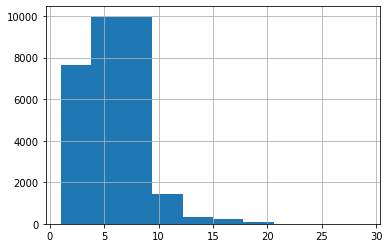

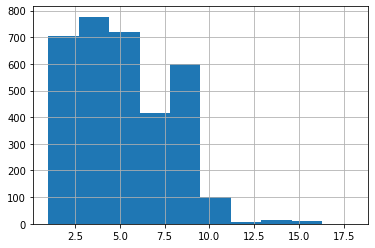

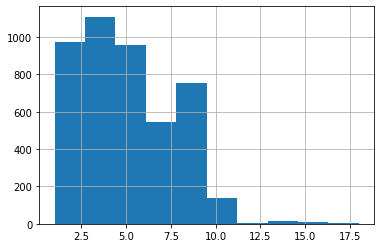

In [10]:
for source in ['vk.com', 'facebook.com', 'youtube.com']:
    total_df[total_df['source']==source]['postId'].value_counts().hist()
    plt.show()

In [16]:
df = pd.read_csv(f'../DATA/BrandSocmediaDashboard/processed/{filename}-processed.csv', sep=';')

/home/analyst/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
total_df.drop_duplicates(subset=['postId', 'brands'])['postId'].value_counts()

-77301947_3762079                    4
-110697506_341264                    3
-136313405_785405                    3
-171844437_101918                    3
-36857673_420134                     3
                                    ..
-70967848_18719                      1
1346457067163418635                  1
-67813557_44049143_382212            1
3393087850931876_3393121690928492    1
1376888944_97244                     1
Name: postId, Length: 2886, dtype: int64

In [11]:
total_df['brands'] = total_df['brands'].astype(str)

In [22]:
total_df = total_df.drop_duplicates(subset=['postId', 'brands'])

In [42]:
file_m = sorted([f for f in os.listdir('DATA') if brand+'_modeled' in f])[-1]
file_y = sorted([f for f in os.listdir('DATA') if brand+'_youscan' in f])[-1]
upload_to_aws(f'DATA/{file_m}', \
             f'dashboard-table_bsd_{brand}_modeled.csv')
upload_to_aws(f'DATA/{file_y}', \
             f'dashboard-table_bsd_{brand}_youscan.csv')

NameError: name 'upload_to_aws' is not defined